<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        🐱🐶 Cat or Dog? Binary Classification using Deep Learning 🧠📊
    </p>
</div>


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 About the Dataset 🐱🐶
    </p>
    <p style="font-size: 1.0em; font-family: 'Arial', sans-serif; text-align: justify; line-height: 1.5; padding: 10px;">
        This dataset contains two classes of images: <a href = "https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset"><b>Cats</b> and <b>Dogs</b></a>. It is well-suited for binary classification tasks in computer vision, where the objective is to build a model that can differentiate between these two categories. Each image in the dataset is labeled accordingly, making it an excellent resource for training, validating, and testing deep learning models focused on binary image classification.
    </p>
</div>


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Import Libraries 🐱🐶
    </p>
</div>


In [24]:
!pip install mplcursors

In [29]:
import os
import PIL
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
import matplotlib.pyplot as plt
import mplcursors
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📂 Helper Functions
    </p>
</div>


### <b><i><center> Cruppted Image Remover

In [2]:
corrupted_images = []

def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return True
    except (IOError, SyntaxError, PIL.UnidentifiedImageError):
        print(f"Corrupted image: {image_path}")
        corrupted_images.append(image_path)
        return False

### <b><i><center> Evaluation Plotter

In [26]:
def plot_plots(data):
    # Use a dark theme
    plt.style.use('dark_background')

    # Plot Loss
    plt.figure(figsize=(10, 5))
    ax = data[['loss', 'val_loss']].plot(color=['cyan', 'magenta'], linewidth=2)
    ax.set_xlabel('Epochs', color='white')
    ax.set_ylabel('Loss', color='white')
    ax.set_title('Loss Over Epochs', color='white')
    ax.tick_params(colors='white')  # Set tick color

    # Adding interactivity with mplcursors
    mplcursors.cursor(ax, hover=True)
    plt.legend(labels=['Training Loss', 'Validation Loss'], loc='upper right', facecolor='black', edgecolor='white', fontsize=10)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    ax = data[['accuracy', 'val_accuracy']].plot(color=['lime', 'orange'], linewidth=2)
    ax.set_xlabel('Epochs', color='white')
    ax.set_ylabel('Accuracy', color='white')
    ax.set_title('Accuracy Over Epochs', color='white')
    ax.tick_params(colors='white')  # Set tick color

    # Adding interactivity with mplcursors
    mplcursors.cursor(ax, hover=True)
    plt.legend(labels=['Training Accuracy', 'Validation Accuracy'], loc='lower right', facecolor='black', edgecolor='white', fontsize=10)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Loading Data From <b>KAGGLE</b> 🐱🐶
    </p>
</div>


In [3]:
import kagglehub
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:06<00:00, 122MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [4]:
print("Path to dataset files:", path)
print("Contents of dataset directory:", os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1
Contents of dataset directory: ['readme[1].txt', 'MSR-LA - 3467.docx', 'PetImages']


In [5]:
data_dir = os.path.join(path, 'PetImages')

In [6]:
output_dir = '/content/data'

In [7]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

In [8]:
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'dogs'), exist_ok=True)

In [9]:
cat_images = glob.glob(os.path.join(data_dir, 'Cat', '*'))
dog_images = glob.glob(os.path.join(data_dir, 'Dog', '*'))

In [10]:
cat_images = [img for img in cat_images if is_valid_image(img)]
dog_images = [img for img in dog_images if is_valid_image(img)]

Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg
Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/Thumbs.db
Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/Thumbs.db


In [11]:
random.shuffle(cat_images)
random.shuffle(dog_images)

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📂 Creating and Splitting Data into Train, Validation and Test Sets
    </p>
</div>


In [12]:
train_cats, val_cats, test_cats = cat_images[:11251], cat_images[11251:11876], cat_images[11876:]
train_dogs, val_dogs, test_dogs = dog_images[:11251], dog_images[11251:11876], dog_images[11876:]

### <b><i><center> Moving Images to Folders

In [13]:
for img in train_cats:
    shutil.copy(img, os.path.join(train_dir, 'cats'))
for img in val_cats:
    shutil.copy(img, os.path.join(val_dir, 'cats'))
for img in test_cats:
    shutil.copy(img, os.path.join(test_dir, 'cats'))

for img in train_dogs:
    shutil.copy(img, os.path.join(train_dir, 'dogs'))
for img in val_dogs:
    shutil.copy(img, os.path.join(val_dir, 'dogs'))
for img in test_dogs:
    shutil.copy(img, os.path.join(test_dir, 'dogs'))

print("Data split and stored in '/content/data' directory")

Data split and stored in '/content/data' directory


In [14]:
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        🗂️ Preparing Data Generators for Training, Validation and Testing
    </p>
    <p style="font-size: 1.0em; font-family: 'Arial', sans-serif; text-align: justify; line-height: 1.5; padding: 10px;">
        In this step, we set up data generators to feed images into the model for training and validation. Using TensorFlow's <code>ImageDataGenerator</code>, we preprocess the images by rescaling their pixel values. First, we clean the training and testing directories by removing any invalid images, ensuring a smooth data flow. The data generators are then configured to load images from these directories, resize them to 224x224 pixels, and set a batch size of 32. This setup streamlines the data pipeline, preparing it for efficient model training and evaluation.
    </p>
</div>


In [15]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.1,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

In [16]:
train_generator = train_gen.flow_from_directory(
        '/content/data/train',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

val_generator = val_gen.flow_from_directory(
        '/content/data/val',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

test_generator = test_gen.flow_from_directory(
        '/content/data/test',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

Found 22502 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1246 images belonging to 2 classes.


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        🏗️ Building a CNN Model From Scratch
    </p>
</div>


In [17]:
model = tf.keras.models.Sequential()

# first layer
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# 2nd layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# 3rd layer
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))


# 4tg layer
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# flattening
model.add(Flatten())

# fully connected
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        🌐 Model Summary
    </p>
</div>


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,829,057 (37.49 MB)

 Trainable params: 9,827,585 (37.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        ⚙️ Compiling Model
    </p>
</div>


In [19]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        ⚙️ Training the Model
    </p>
</div>


In [20]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.6121 - loss: 0.8723 - val_accuracy: 0.5000 - val_loss: 1.5636
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.7517 - loss: 0.5043 - val_accuracy: 0.5208 - val_loss: 1.1427
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8202 - loss: 0.3946 - val_accuracy: 0.6696 - val_loss: 0.6552
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8627 - loss: 0.3130 - val_accuracy: 0.7952 - val_loss: 0.4832
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8849 - loss: 0.2709 - val_accuracy: 0.8968 - val_loss: 0.2646
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9012 - loss: 0.2384 - val_accuracy: 0.8424 - val_loss: 0.4966
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9135 - loss: 0.2157 - val_accuracy: 0.9040 - val_loss: 0.2261
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9200 - loss: 0.1945 - val_accuracy: 0.862

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Evaluating Model Performance (Loss and Accuracy)
    </p>
</div>


In [21]:
result = pd.DataFrame(history.history)
result.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.902231,0.235716,0.8424,0.496604
6,0.911741,0.214103,0.9040,0.226119
7,0.919296,0.196052,0.8624,0.328196
8,0.924896,0.183670,0.9240,0.201572
9,0.929251,0.175982,0.9400,0.164008


<Figure size 1000x500 with 0 Axes>

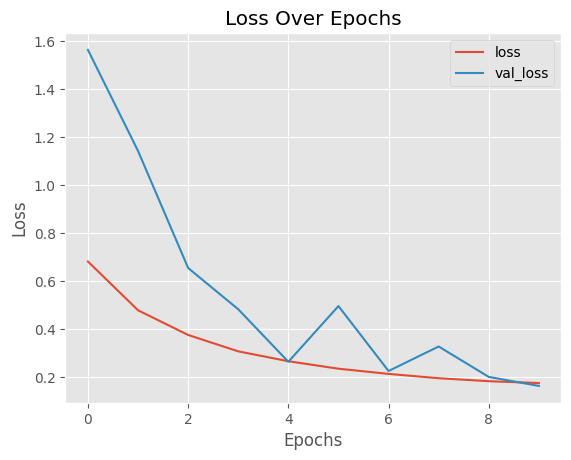

<Figure size 1000x500 with 0 Axes>

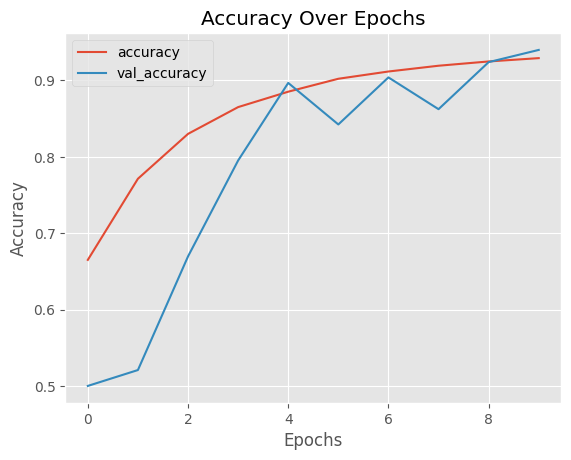

In [27]:
plot_plots(result)

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Evaluating Model Performance on Test Data
    </p>
</div>


In [28]:
evaluation = model.evaluate(test_generator)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 753ms/step - accuracy: 0.9336 - loss: 0.1645
Test Accuracy: 93.50%


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        🏗️ Building a Transfer Learning Model
    </p>
    <p style="font-size: 1.0em; font-family: 'Arial', sans-serif; text-align: justify; line-height: 1.5; padding: 10px;">
        Here, we define a function to create a transfer learning model using TensorFlow Hub. This function, <code>create_model</code>, accepts a URL for a pre-trained model and the number of output classes. It builds a model with two main components: a pre-trained feature extraction layer that captures high-level patterns from the input images, and a dense output layer for binary classification. By freezing the feature extraction layer, we focus on training only the output layer, which helps speed up the training process and reduce the risk of overfitting. This approach efficiently adapts a powerful pre-trained model for our specific classification task.
    </p>
</div>


In [31]:
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"
mobilenet_url = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/1"

In [32]:
IMAGE_SHAPE = (224,224)
def create_model(model_url, num_classes):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))


  model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.Dense(num_classes, activation='sigmoid', name='output_layer')

  ])
  return model

<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        ⚙️ Transfer Learning with ResNet Model
    </p>
</div>


In [33]:
resnet_model = create_model(resnet_url, num_classes=1)

resnet_model.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])

resnet_history = resnet_model.fit(train_generator,
                                  validation_data=val_generator,
                                  epochs=5,
                                  steps_per_epoch=len(train_generator),
                                  validation_steps=len(val_generator)
                                  )

Epoch 1/5
 90/176 [==============>...............] - ETA: 2:33 - loss: 0.6718 - accuracy: 0.8858

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 359s 2s/step - loss: 0.6570 - accuracy: 0.9267 - val_loss: 0.6258 - val_accuracy: 0.9688
Epoch 2/5
176/176 [==============================] - 309s 2s/step - loss: 0.5997 - accuracy: 0.9731 - val_loss: 0.5707 - val_accuracy: 0.9672
Epoch 3/5
176/176 [==============================] - 334s 2s/step - loss: 0.5486 - accuracy: 0.9720 - val_loss: 0.5201 - val_accuracy: 0.9704
Epoch 4/5
176/176 [==============================] - 300s 2s/step - loss: 0.5026 - accuracy: 0.9724 - val_loss: 0.4758 - val_accuracy: 0.9728
Epoch 5/5
176/176 [==============================] - 301s 2s/step - loss: 0.4625 - accuracy: 0.9709 - val_loss: 0.4380 - val_accuracy: 0.9656


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Evaluation on ResNet
    </p>
</div>


<Figure size 1000x500 with 0 Axes>

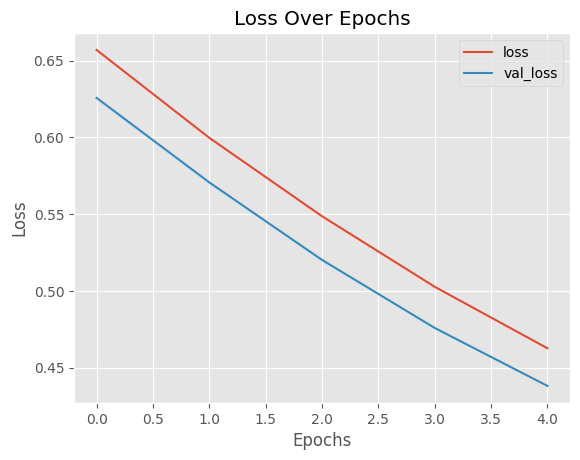

<Figure size 1000x500 with 0 Axes>

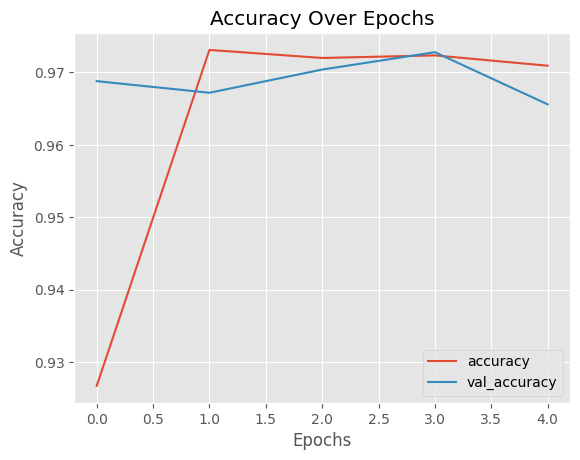

In [34]:
plot_plots(pd.DataFrame(resnet_history.history))

In [36]:
test_loss, test_accuracy = resnet_model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 4s 444ms/step - loss: 0.4327 - accuracy: 0.9839
Test Loss: 0.4327
Test Accuracy: 98.39%


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        ⚙️ Transfer Learning with EfficientNet Model
    </p>
</div>


In [37]:
efficientnet_model = create_model(efficientnet_url, num_classes=1)

efficientnet_model.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_generator,
                                  validation_data=val_generator,
                                  epochs=5,
                                  steps_per_epoch=len(train_generator),
                                  validation_steps=len(val_generator)
                                  )

Epoch 1/5
120/176 [===================>..........] - ETA: 1:30 - loss: 0.1270 - accuracy: 0.9532

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 306s 2s/step - loss: 0.1106 - accuracy: 0.9594 - val_loss: 0.0569 - val_accuracy: 0.9776
Epoch 2/5
176/176 [==============================] - 284s 2s/step - loss: 0.0639 - accuracy: 0.9764 - val_loss: 0.0399 - val_accuracy: 0.9896
Epoch 3/5
176/176 [==============================] - 284s 2s/step - loss: 0.0590 - accuracy: 0.9774 - val_loss: 0.0416 - val_accuracy: 0.9888
Epoch 4/5
176/176 [==============================] - 285s 2s/step - loss: 0.0560 - accuracy: 0.9783 - val_loss: 0.0439 - val_accuracy: 0.9832
Epoch 5/5
176/176 [==============================] - 286s 2s/step - loss: 0.0556 - accuracy: 0.9780 - val_loss: 0.0414 - val_accuracy: 0.9856


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Evaluation on EfficientNet
    </p>
</div>


<Figure size 1000x500 with 0 Axes>

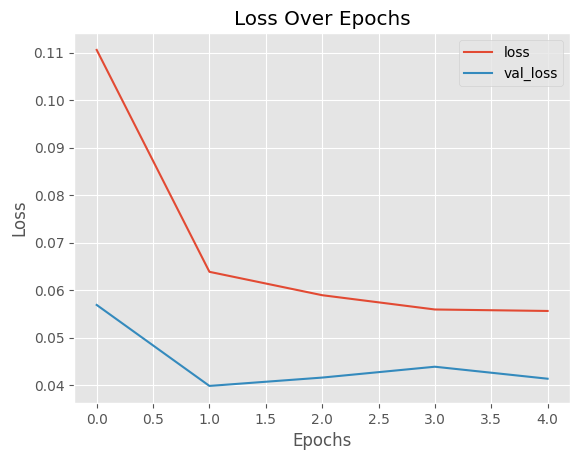

<Figure size 1000x500 with 0 Axes>

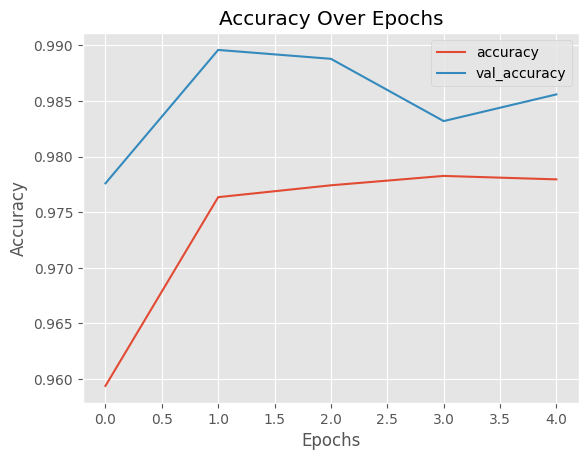

In [38]:
plot_plots(pd.DataFrame(efficientnet_history.history))

In [39]:
test_loss, test_accuracy = efficientnet_model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 5s 525ms/step - loss: 0.0321 - accuracy: 0.9888
Test Loss: 0.0321
Test Accuracy: 98.88%


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        ⚙️ Transfer Learning with MobileNet Model
    </p>
</div>


In [40]:
mobilenet_model = create_model(mobilenet_url, num_classes=1)

mobilenet_model.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_generator,
                                  validation_data=val_generator,
                                  epochs=5,
                                  steps_per_epoch=len(train_generator),
                                  validation_steps=len(val_generator)
                                  )

Epoch 1/5
 85/176 [=============>................] - ETA: 2:24 - loss: 0.1932 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 295s 2s/step - loss: 0.1297 - accuracy: 0.9587 - val_loss: 0.0645 - val_accuracy: 0.9784
Epoch 2/5
176/176 [==============================] - 283s 2s/step - loss: 0.0525 - accuracy: 0.9833 - val_loss: 0.0445 - val_accuracy: 0.9824
Epoch 3/5
176/176 [==============================] - 280s 2s/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0503 - val_accuracy: 0.9824
Epoch 4/5
176/176 [==============================] - 280s 2s/step - loss: 0.0414 - accuracy: 0.9853 - val_loss: 0.0454 - val_accuracy: 0.9824
Epoch 5/5
176/176 [==============================] - 279s 2s/step - loss: 0.0402 - accuracy: 0.9851 - val_loss: 0.0443 - val_accuracy: 0.9840


<div style="text-align: center;">
    <p style="background-color: #8aeb92; color: #910909; font-size: 2.0em; font-family: 'Arial', sans-serif; text-align: center; border-radius: 25px; border: 4px solid #910909; display: inline-block; padding: 20px 20px; margin: 0 auto; line-height: 1.5; font-weight: bold; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.3);">
        📊 Evaluation on MobileNet
    </p>
</div>


<Figure size 1000x500 with 0 Axes>

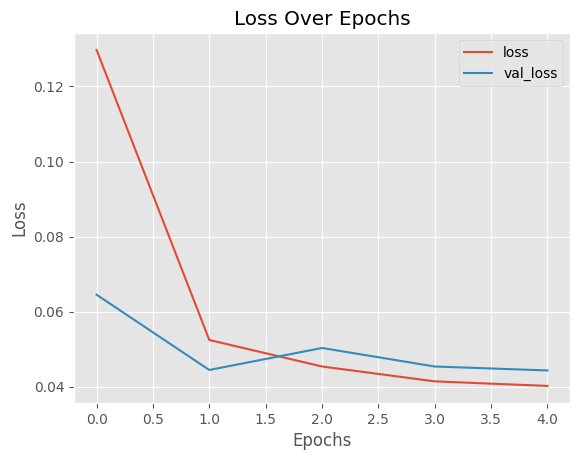

<Figure size 1000x500 with 0 Axes>

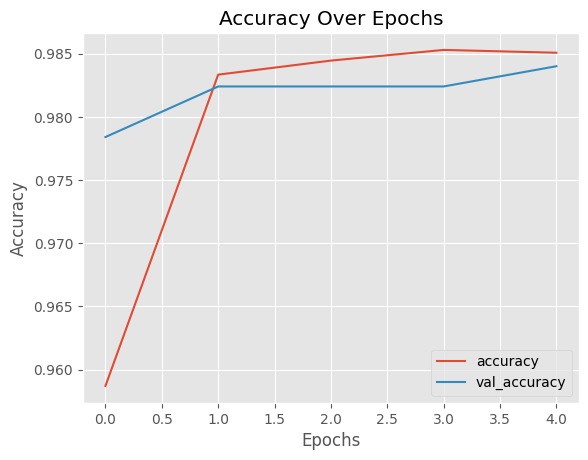

In [41]:
plot_plots(pd.DataFrame(mobilenet_history.history))

In [42]:
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 4s 432ms/step - loss: 0.0308 - accuracy: 0.9896
Test Loss: 0.0308
Test Accuracy: 98.96%
